In [ ]:
import random

import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from tqdm import trange

import torch
from torch import nn

source = "../source"
sys.path.append(source)


from data import seq_data
from preprocessing import OneHot
from compilation import Compiler, ScalarTracker, ActivationTracker
from data_analysis.automata import (
    to_automaton_history,
    reduce_automaton,
    to_automaton,
    gen_rand_automaton,
    gen_tree,
)
from visualization.animation import SliderAnimation
from visualization.activations import ActivationsAnimation
from visualization.automata import AutomatonAnimation, display_automata
from visualization.epochs import EpochAnimation

from model import Model
import publication

is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [2]:
save = False

In [3]:
## Load settings
settings = "rich"

(nonlinearity, gain, lr, P, L, n_epochs, max_seq_len) = (
    pd.read_csv("model settings/rnn.txt", sep=" ", header=0).loc[settings].to_numpy()
)
P, L, n_epochs, max_seq_len = int(P), int(L), int(n_epochs), int(max_seq_len)

In [4]:
gain = 0.0000000001
max_seq_len = 10
lr = 0.00025
n_epochs = 400
P = 100
problem_size = 5

In [5]:
gain = 0.0000000001
max_seq_len = 10
lr = 0.001
n_epochs = 100
P = 100
problem_size = 4

In [6]:
## Generate data

# Define problem and data encoding
symbols = [0, 1]
encoding = OneHot(symbols)
automaton = gen_rand_automaton(symbols, [[1, 0], [0, 1]], problem_size, 0.6)
problem = lambda seq: int(np.argmax(automaton.compute(seq)))

# Define sequence lengths for training and validation datasets
train_seq_lengths = list(range(1, max_seq_len + 1))
# analysis_seq_lengths = train_seq_lengths
analysis_seq_lengths = list(range(1, 10 + 1))
val_seq_length = 50
val_datapoints = 32

# Generate datasets
training_datasets = [
    seq_data(device, problem, encoding, seq_len=length) for length in train_seq_lengths
]
validation_datasets = [
    seq_data(
        device, problem, encoding, n_datapoints=val_datapoints, seq_len=val_seq_length
    )
]
analysis_data = [
    seq_data(device, problem, encoding, seq_len=length)
    for length in analysis_seq_lengths
]
tracked_datasets = validation_datasets + analysis_data + training_datasets

In [ ]:
display_automata(automaton)

In [8]:
## Instantiate model
model = Model(
    encoding=encoding,
    input_size=len(symbols),
    output_size=len(symbols),
    hidden_dim=P,
    n_layers=L,
    device=device,
    nonlinearity=nonlinearity,
    gain=gain,
)

In [9]:
## Setup compiler
criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss()
n_epochs = n_epochs * 7
optimizer = torch.optim.SGD(model.parameters(), lr=50 * lr, momentum=0)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr, amsgrad=True, weight_decay=0.00)
compiler = Compiler(model, criterion, optimizer)
initial_hidden = model.init_hidden(batch_size=1)[-1]
hidden_function = lambda inputs: model(inputs)[1][-1]
output_function = lambda inputs: model(inputs)[0]
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    "hidden": ActivationTracker(
        encoding,
        hidden_function,
        analysis_data,
        initial=lambda: initial_hidden,
    ),
    "output": ActivationTracker(encoding, output_function, analysis_data),
}

In [ ]:
## Training run
compiler.training_run(
    training_datasets,
    n_epochs=n_epochs,
    batch_size=128,
)

In [ ]:
loss = compiler.trackers["loss"].get_trace()
val_loss = loss.query("Dataset==0")[0].to_numpy()
train_loss = loss.query("Dataset>0").groupby("Epoch").mean()
n_datapoints = sum(len(dataset) for dataset in training_datasets)

publication.set_color_mixed()
plt.figure(figsize=(3, 2))
plt.plot(train_loss, label="Training loss")
plt.plot(val_loss, label="Validation loss")
plt.xlabel("epochs")
plt.ylim(0)
# plt.legend()
if save:
    publication.plt_show(save_path=f"plots/automaton_dynamics/{settings}_loss_small")
else:
    publication.plt_show()

In [ ]:
learned_automaton = to_automaton(
    hidden_function,
    output_function,
    initial_hidden,
    training_datasets,
    encoding,
    merge_distance_frac=1,
)
display_automata(learned_automaton)
if save:
    publication.pub_show(save_path=f"plots/automaton_dynamics/{settings}_automaton")
else:
    publication.pub_show()
display_automata(reduce_automaton(learned_automaton))
if save:
    publication.pub_show(
        save_path=f"plots/automaton_dynamics/{settings}_automaton_reduced"
    )
else:
    publication.pub_show()

In [ ]:
display_automata(reduce_automaton(automaton))

In [ ]:
## Visualize automaton dynamics

# Filter and process data for visualization
data_hid = compiler.trackers["hidden"].get_trace()
data_output = compiler.trackers["output"].get_trace()
query = "(Dataset <= 12)"
data_hid = data_hid.query(query).copy()
data_output = data_output.query(query).copy()

epochs = list(set(data_hid.index.get_level_values("Epoch")))
epochs.sort()

std = float(np.linalg.norm(data_hid.std()))
n_points = len(data_hid.query("Epoch == 0"))

automaton_history = to_automaton_history(
    data_hid, data_output, merge_distance=0.01 * std
)
loss = compiler.trackers["loss"].get_trace()
val_loss = loss.query("Dataset==0")[0].to_numpy()
train_loss = loss.query("Dataset>0").groupby("Epoch").mean()
n_states = np.array([len(automaton.states) for automaton in automaton_history])
is_finite = np.array([automaton.is_finite() for automaton in automaton_history])

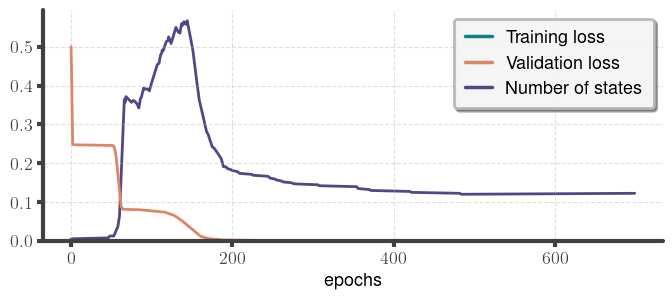

In [31]:
n_datapoints = sum(len(dataset) for dataset in analysis_data)

publication.set_color_mixed()
plt.figure(figsize=(8, 3))
plt.plot(np.array(train_loss[0]), label="Training loss")
plt.plot(val_loss, label="Validation loss")
# plt.plot(n_states / n_datapoints, label="Number of states", zorder=0, color="0.5")
plt.plot(5 * n_states / n_datapoints, label="Number of states", zorder=0)
# plt.plot(n_exit / n_datapoints)
plt.xlabel("epochs")
plt.ylim(0)
plt.legend()
if save:
    publication.plt_show(save_path=f"plots/automaton_dynamics/{settings}_loss")
else:
    publication.plt_show()

In [ ]:
import scipy

last_epoch = int(data_hid.index.get_level_values("Epoch")[-1])
data_hid_analyze = data_hid.query("Dataset != -1 and Dataset <= 2").query(
    f"Epoch == {last_epoch}"
)

h = data_hid_analyze.to_numpy()
H = scipy.spatial.distance_matrix(h, h)

labels = data_hid_analyze.index.get_level_values("Input").to_numpy()

plt.figure(figsize=(4, 4))
publication.set_color_gradient(0)
plt.imshow(H.astype(float))
plt.title("Representational distance")
publication.im_show(x_labels=labels, y_labels=labels)

In [17]:
########### learn algorithm with uneven data distribution over states, so merging happens in steps

In [18]:
## compute percentage merged as function of seq len

In [19]:
## ON TRANSFORMER TEST BEHAVIOUR ON ARBITRAY LONG RANGE SEQUENCE

In [ ]:
## Check for large sequence length generalization

# Evaluate model generalization for sequences of varying lengths
N = 500
val_data = []
for n in trange(1, N + 1):
    val_data.append(seq_data(device, problem, encoding, n_datapoints=10, seq_len=n))
val_err = compiler.validation(val_data).to_numpy()[:, 0]

# Visualize validation error for varying sequence lengths
publication.set_color_mixed()
fig = plt.figure(figsize=(6, 2))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.bar(np.arange(1, N + 1), val_err, color="skyblue")
ax.set_xlabel("Sequence lengths")
ax.set_ylabel("Validation error")
# ax.set_title("Model Generalization Across Sequence Lengths")
ax.set_yticks(np.arange(0, 1, 0.1))
if save:
    publication.pub_show(save_path=f"plots/automaton_dynamics/{settings}_validation")
else:
    publication.pub_show()

In [23]:
hid_1 = hid_1_full.query(f"Epoch == {last_epoch}")
h_1 = hid_1.to_numpy()
labels_1 = hid_1.index.get_level_values("Input").to_numpy()
outputs_1 = [problem(list(map(int, x))) for x in labels_1]

hid_2 = hid_2_full.query(f"Epoch == {last_epoch}")
h_2 = hid_2.to_numpy()
H = scipy.spatial.distance_matrix(h_1, h_2)
mergers = H < cutoff

labels_2 = hid_2.index.get_level_values("Input").to_numpy()
outputs_2 = [problem(list(map(int, x))) for x in labels_2]

possible_mergers = np.array([[y_1 == y_2 for y_2 in outputs_2] for y_1 in outputs_1])
possible_mergers_sum = int(np.sum(possible_mergers) / 2)
count = int(np.sum(mergers) / 2)

diverging_mergers = mergers
never_splits = np.full(mergers.shape, True)
for epoch in range(last_epoch):
    h_1_epoch = hid_1_full.query(f"Epoch == {epoch}").to_numpy()
    h_2_epoch = hid_2_full.query(f"Epoch == {epoch}").to_numpy()
    H_epoch = scipy.spatial.distance_matrix(h_1_epoch, h_2_epoch)
    mergers_epoch = H < cutoff
    never_splits = never_splits * mergers_epoch
diverging_merger_count = np.sum(mergers * (1 - never_splits))

In [ ]:
## Plot number of diverging state mergers per sequence length pairs
last_epoch = int(data_hid.index.get_level_values("Epoch")[-1])
data_hid_analyze = data_hid.query("Dataset != -1")
cutoff = 0.05 * std


merger_counts = np.zeros((len(training_datasets), len(training_datasets)))
diverging_merger_counts = np.zeros((len(training_datasets), len(training_datasets)))
total_mergers = 0
total_possible_mergers = 0
total_pred_mergers = 0
total_unpred_mergers = 0
total_diverging_mergers = 0
for dataset_1, hid_1_full in data_hid_analyze.groupby("Dataset"):
    print(dataset_1)
    hid_1 = hid_1_full.query(f"Epoch == {last_epoch}")
    h_1 = hid_1.to_numpy()
    labels_1 = hid_1.index.get_level_values("Input").to_numpy()
    outputs_1 = [problem(list(map(int, x))) for x in labels_1]
    for dataset_2, hid_2_full in data_hid_analyze.groupby("Dataset"):
        hid_2 = hid_2_full.query(f"Epoch == {last_epoch}")
        if dataset_1 == 0 and dataset_2 == 0:
            break
        h_2 = hid_2.to_numpy()
        H = scipy.spatial.distance_matrix(h_1, h_2)
        mergers = H < cutoff

        labels_2 = hid_2.index.get_level_values("Input").to_numpy()
        outputs_2 = [problem(list(map(int, x))) for x in labels_2]

        possible_mergers = np.array(
            [[y_1 == y_2 for y_2 in outputs_2] for y_1 in outputs_1]
        )
        possible_mergers_sum = int(np.sum(possible_mergers) / 2)
        if dataset_1 == dataset_2:
            np.fill_diagonal(mergers, False)
            possible_mergers_sum -= len(hid_1) / 2
        count = int(np.sum(mergers) / 2)
        merger_counts[dataset_1, dataset_2] = count / possible_mergers_sum

        diverging_mergers = mergers
        never_splits = np.full(mergers.shape, True)
        for epoch in range(last_epoch):
            h_1_epoch = hid_1_full.query(f"Epoch == {epoch}").to_numpy()
            h_2_epoch = hid_2_full.query(f"Epoch == {epoch}").to_numpy()
            H_epoch = scipy.spatial.distance_matrix(h_1_epoch, h_2_epoch)
            mergers_epoch = H_epoch < cutoff
            # mergers_epoch = H_epoch < 10 * H
            never_splits = never_splits * mergers_epoch
        diverging_merger_count = int(np.sum(mergers * (1 - never_splits)) / 2)
        diverging_merger_counts[dataset_1, dataset_2] = (
            diverging_merger_count / possible_mergers_sum
        )

        total_mergers += count
        total_possible_mergers += int(possible_mergers_sum)
        total_pred_mergers += int(np.sum(mergers * possible_mergers) / 2)
        total_unpred_mergers += int(np.sum(mergers * np.invert(possible_mergers)) / 2)
        total_diverging_mergers += diverging_merger_count

In [ ]:
labels = np.arange(1, len(training_datasets) + 1)
plt.figure(figsize=(4, 4))
publication.set_color_gradient(0)
plt.imshow(merger_counts)
plt.xlabel("Sequence length")
plt.ylabel("Sequence length")
plt.title("Fraction of possible mergers")
publication.im_show(
    x_labels=labels,
    y_labels=labels,
    save_path=f"plots/{settings}_mergers",
)

plt.figure(figsize=(4, 4))
publication.set_color_gradient(0)
plt.imshow(diverging_merger_counts)
plt.xlabel("Sequence length")
plt.ylabel("Sequence length")
plt.title("Fraction of possible mergers")
publication.im_show(
    x_labels=labels,
    y_labels=labels,
    save_path=f"plots/{settings}_diverging_mergers",
)

c = 0.3
plt.figure(figsize=(4, 4))
publication.set_color_gradient(0)
plt.imshow(
    (np.minimum.outer(labels, labels) >= 5)
    * np.abs(np.subtract.outer(c**labels, c**labels))
)
plt.xlabel("Sequence length")
plt.ylabel("Sequence length")
plt.title("Fraction of possible mergers")
publication.im_show(
    x_labels=labels,
    y_labels=labels,
    # save_path=f"plots/{settings}_mergers",
)


print(f"Total mergers: {total_mergers}")
print(f"Total possible mergers: {total_possible_mergers}")
print(f"Total unpredicted mergers: {total_unpred_mergers}")
print(f"Total predicted mergers: {total_pred_mergers}")

In [ ]:
plt.figure(figsize=(4, 4))
publication.set_color_gradient(0)
plt.imshow(diverging_merger_counts / (merger_counts + 0.000000001))
plt.xlabel("Sequence length")
plt.ylabel("Sequence length")
plt.title("Fraction of possible mergers")
publication.im_show(
    x_labels=labels,
    y_labels=labels,
    # save_path=f"plots/{settings}_mergers",
)


c = 0.25

plt.figure(figsize=(4, 4))
publication.set_color_gradient(0)
plt.imshow(
    (np.minimum.outer(labels, labels) >= 5)
    * np.abs(np.subtract.outer(c**labels, c**labels))
)
plt.xlabel("Sequence length")
plt.ylabel("Sequence length")
plt.title("Fraction of possible mergers")
publication.im_show(
    x_labels=labels,
    y_labels=labels,
    # save_path=f"plots/{settings}_mergers",
)

plt.figure(figsize=(4, 4))
publication.set_color_gradient(0)
plt.imshow((np.minimum.outer(labels, labels) >= 5))
plt.xlabel("Sequence length")
plt.ylabel("Sequence length")
plt.title("Fraction of possible mergers")
publication.im_show(
    x_labels=labels,
    y_labels=labels,
    # save_path=f"plots/{settings}_mergers",
)

plt.figure(figsize=(4, 4))
publication.set_color_gradient(0)
plt.imshow(np.abs(np.subtract.outer(c**labels, c**labels)))
plt.xlabel("Sequence length")
plt.ylabel("Sequence length")
plt.title("Fraction of possible mergers")
publication.im_show(
    x_labels=labels,
    y_labels=labels,
    # save_path=f"plots/{settings}_mergers",
)

In [ ]:
# ## Plot number of state mergers per sequence length pairs
# last_epoch = int(data_hid.index.get_level_values("Epoch")[-1])
# data_hid_analyze = data_hid.query("Dataset != -1").query(f"Epoch == {last_epoch}")
# cutoff = 0.01 * std


# merger_counts = np.zeros((len(training_datasets), len(training_datasets)))
# total_mergers = 0
# total_possible_mergers = 0
# total_pred_mergers = 0
# total_unpred_mergers = 0
# for dataset_1, hid_1 in data_hid_analyze.groupby("Dataset"):
#     h_1 = hid_1.to_numpy()
#     labels_1 = hid_1.index.get_level_values("Input").to_numpy()
#     outputs_1 = [problem(list(map(int, x))) for x in labels_1]
#     for dataset_2, hid_2 in data_hid_analyze.groupby("Dataset"):
#         if dataset_1 == 0 and dataset_2 == 0:
#             break
#         h_2 = hid_2.to_numpy()
#         labels_2 = hid_2.index.get_level_values("Input").to_numpy()
#         outputs_2 = [problem(list(map(int, x))) for x in labels_2]
#         H = scipy.spatial.distance_matrix(h_1, h_2)
#         mergers = H < cutoff
#         possible_mergers = np.array(
#             [[y_1 == y_2 for y_2 in outputs_2] for y_1 in outputs_1]
#         )
#         possible_mergers_sum = int(np.sum(possible_mergers) / 2)
#         if dataset_1 == dataset_2:
#             np.fill_diagonal(mergers, False)
#             possible_mergers_sum -= len(hid_1) / 2
#         count = int(np.sum(mergers) / 2)
#         merger_counts[dataset_1, dataset_2] = count / possible_mergers_sum

#         total_mergers += count
#         total_possible_mergers += int(possible_mergers_sum)
#         total_pred_mergers += int(np.sum(mergers * possible_mergers) / 2)
#         total_unpred_mergers += int(np.sum(mergers * np.invert(possible_mergers)) / 2)

# labels = np.arange(1, len(training_datasets) + 1)
# plt.figure(figsize=(4, 4))
# publication.set_color_gradient(0)
# plt.imshow(merger_counts)
# plt.xlabel("Sequence length")
# plt.ylabel("Sequence length")
# plt.title("Fraction of possible mergers")
# publication.im_show(
#     x_labels=labels,
#     y_labels=labels,
#     save_path=f"plots/{settings}_mergers",
# )
# print(f"Total mergers: {total_mergers}")
# print(f"Total possible mergers: {total_possible_mergers}")
# print(f"Total unpredicted mergers: {total_unpred_mergers}")
# print(f"Total predicted mergers: {total_pred_mergers}")

In [29]:
# # Create animation
# plot_labels = False
# publication.set_color_mixed()
# animation = SliderAnimation(
#     {
#         "Hidden representations": ActivationsAnimation(
#             data_hid,
#             transform="PCA",
#             colors=[5] * n_points,
#             plot_labels=plot_labels,
#         ),
#         "Output": ActivationsAnimation(
#             data_output,
#             transform="none",
#             fixed_points=encoding.encoding,
#             colors=[6] * n_points,
#             plot_labels=plot_labels,
#         ),
#         "Automaton": AutomatonAnimation(automaton_history, reduce_automata=True),
#         "Loss": EpochAnimation(
#             graphs={
#                 "Training loss": train_loss,
#                 "Validation loss": val_loss,
#             },
#             unitless_graphs={
#                 "Number of states": n_states,
#             },
#             y_bounds=(0, 1),
#         ),
#     },
#     parameters=epochs,
#     parameter_name="Epoch",
#     fig_size=4,
# )

# # Optionally export the animation
# if save:
#     animation.to_gif(f"plots/automaton_dynamics_{settings}")

In [30]:
# animation.to_gif(f"plots/automaton_dynamics_reduced_{settings}")

In [31]:
# match settings:
#     case "rich":
#         epoch_choices = [0, 1000, 1999]
#     case "intermediate":
#         epoch_choices = [0, 350, 660, 1999]
#     case "lazy":
#         epoch_choices = [0, 1999]
#     case "low_data":
#         epoch_choices = [0, 600,1999]

# for epoch in epoch_choices:
#     automaton = automaton_history[epoch]
#     display_automata(automaton)
#     if save:
#         publication.pub_show(
#             save_path=f"plots/automaton_dynamics/{settings}_automaton_epoch_{epoch}"
#         )
#     else:
#         publication.pub_show()

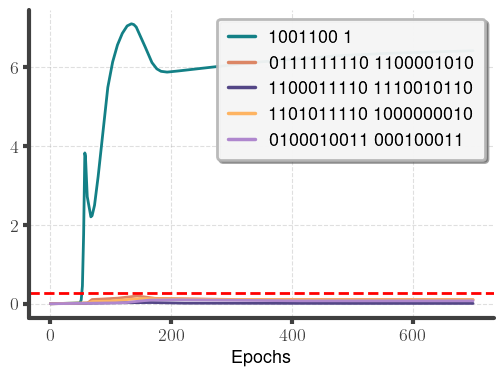

In [50]:
## Plot trajectories

# Get data
data_hid = compiler.trackers["hidden"].get_trace()
data_output = compiler.trackers["output"].get_trace()

loss = compiler.trackers["loss"].get_trace().copy()
train_loss = loss.groupby("Epoch").mean()
train_loss = train_loss.to_numpy().ravel()

epochs = list(set(data_output.index.get_level_values("Epoch")))
epochs.sort()
# A_label_sim = ["010001110", "00", "0101101011", "0100", "0111"]
# B_label_sim = ["100010110", "11", "0101111100", "1000", "1011"]

N_pairs = 5

labels = set(data_hid.index.get_level_values("Input"))
labels.remove("initial")
labels = list(labels)
# labels = [x for x in labels if len(x) == 8]

A_label_sim = random.sample(labels, N_pairs)
B_label_sim = []
for a in A_label_sim:
    while True:
        b = np.random.choice(labels)
        if (
            problem(list(map(int, a))) == problem(list(map(int, b)))
            and a != b
            and b not in B_label_sim
        ):
            B_label_sim.append(b)
            break

h_A_sim = [
    np.array(data.loc[epoch, :, A_label_sim])
    for epoch, data in data_hid.groupby("Epoch")
]
h_B_sim = [
    np.array(data.loc[epoch, :, B_label_sim])
    for epoch, data in data_hid.groupby("Epoch")
]
h2_sim = np.array(
    [np.sum((h_A_sim[epoch] - h_B_sim[epoch]) ** 2, axis=1) for epoch in epochs]
)

# A_label_diff = ["01011001", "010110011", "10"]
# B_label_diff = ["11011010", "110110101", "01"]

A_label_diff = random.sample(labels, N_pairs)
B_label_diff = []
for a in A_label_diff:
    while True:
        b = np.random.choice(labels)
        if (
            problem(list(map(int, a))) != problem(list(map(int, b)))
            and a != b
            and b not in B_label_diff
        ):
            B_label_diff.append(b)
            break

h_A_diff = [
    np.array(data.loc[epoch, :, A_label_diff])
    for epoch, data in data_hid.groupby("Epoch")
]
h_B_diff = [
    np.array(data.loc[epoch, :, B_label_diff])
    for epoch, data in data_hid.groupby("Epoch")
]
h2_diff = np.array(
    [np.sum((h_A_diff[epoch] - h_B_diff[epoch]) ** 2, axis=1) for epoch in epochs]
)

t = np.linspace(0, len(epochs), len(epochs))

## Plot trajectories
traj_path = "plots/2_points/trajectories/"

publication.set_color_mixed()
figsize = (6, 4)
fig, ax = plt.subplots(figsize=figsize)
for k, h in enumerate(np.transpose(h2_sim)):
    # plt.gca().set_prop_cycle(None)
    ax.plot(t, h, label=f"{A_label_sim[k]} {B_label_sim[k]}")
# for k, h in enumerate(np.transpose(h2_diff)):
#     plt.gca().set_prop_cycle(None)
#     publication.skip_colors(1)
#     ax.plot(t, h, label=f"{A_label_diff[k]} {B_label_diff[k]}")
# ax.plot(t, 10 * n_states / max(n_states))
thresh = 0.5 * std
plt.axhline(thresh**2, linestyle="--", color="r")
# plt.ylim(0, 10 * thresh)
# plt.ylim(0, 20)

ax.legend()
plt.xlabel("Epochs")
if save:
    publication.plt_show(save_path=traj_path + "ode/" + settings + ".png")
else:
    publication.plt_show()

In [ ]:
## Plot trajectories

# Get data
data_hid = compiler.trackers["hidden"].get_trace()
data_output = compiler.trackers["output"].get_trace()

loss = compiler.trackers["loss"].get_trace().copy()
train_loss = loss.groupby("Epoch").mean()
train_loss = train_loss.to_numpy().ravel()

epochs = list(set(data_output.index.get_level_values("Epoch")))
epochs.sort()

N_pairs = 10000

labels = set(data_hid.index.get_level_values("Input"))
labels.remove("initial")
labels = list(labels)

A_label = np.random.choice(labels, size=N_pairs)
B_label = np.random.choice(labels, size=N_pairs)

h2_sim, h2_diff = [], []
for k in trange(0, N_pairs):
    a, b = A_label[k], B_label[k]
    h_A = np.array(data_hid.loc[:, :, a])
    h_B = np.array(data_hid.loc[:, :, b])
    h2 = np.sum((h_A - h_B) ** 2, axis=1)
    if problem(list(map(int, a))) == problem(list(map(int, b))):
        h2_sim.append(h2)
    else:
        h2_diff.append(h2)

# h_A_sim = [
#     np.array(data.loc[epoch, :, A_label_sim])
#     for epoch, data in data_hid.groupby("Epoch")
# ]
# h_B_sim = [
#     np.array(data.loc[epoch, :, B_label_sim])
#     for epoch, data in data_hid.groupby("Epoch")
# ]
# h2_sim = np.array(
#     [np.sum((h_A_sim[epoch] - h_B_sim[epoch]) ** 2, axis=1) for epoch in epochs]
# )


# h_A_diff = [
#     np.array(data.loc[epoch, :, A_label_diff])
#     for epoch, data in data_hid.groupby("Epoch")
# ]
# h_B_diff = [
#     np.array(data.loc[epoch, :, B_label_diff])
#     for epoch, data in data_hid.groupby("Epoch")
# ]
# h2_diff = np.array(
#     [np.sum((h_A_diff[epoch] - h_B_diff[epoch]) ** 2, axis=1) for epoch in epochs]
# )

t = np.linspace(0, len(epochs), len(epochs))


# publication.set_color_mixed()
# figsize = (6, 4)
# fig, ax = plt.subplots(figsize=figsize)
# for k, h in enumerate(h2_sim):
#     # plt.gca().set_prop_cycle(None)
#     ax.plot(t, h, label=f"{A_label_sim[k]} {B_label_sim[k]}")
# # for k, h in enumerate(np.transpose(h2_diff)):
# #     plt.gca().set_prop_cycle(None)
# #     publication.skip_colors(1)
# #     ax.plot(t, h, label=f"{A_label_diff[k]} {B_label_diff[k]}")
# # ax.plot(t, 10 * n_states / max(n_states))
# thresh = 0.5 * std
# plt.axhline(thresh**2, linestyle="--", color="r")
# # plt.ylim(0, 10 * thresh)
# # plt.ylim(0, 20)

# ax.legend()
# plt.xlabel("Epochs")
# if save:
#     publication.plt_show(save_path=traj_path + "ode/" + settings + ".png")
# else:
#     publication.plt_show()


thresh = 0.1 * std
indicators_same, indicators_diff = [], []
for k, h in enumerate(h2_sim):
    indicator = h > thresh
    indicators_same.append(indicator)
for k, h in enumerate(h2_diff):
    indicator = h > thresh
    indicators_diff.append(indicator)
sum_same = np.sum(np.array(indicators_same), axis=0)
sum_diff = np.sum(np.array(indicators_diff), axis=0)

plt.figure(figsize=(4, 3))
publication.set_color_mixed()
plt.plot(t, train_loss / np.max(train_loss), label="Training loss")
publication.skip_colors(1)
plt.plot(t, (sum_same + sum_diff) / N_pairs, label="Splits total")
publication.skip_colors(1)
plt.plot(t, sum_same / N_pairs, label="Splits same")
plt.plot(t, sum_diff / N_pairs, label="Splits diff")
# plt.legend()
publication.plt_show(save_path="theory_n_states")

 57%|█████▋    | 5727/10000 [00:16<00:13, 312.63it/s]